## **<span style="color:lime">Second section</span>: *statistics example***
| *Cells* | *Content* |
|---|---|
| 2.1 *Setup* | Imports and helpers |
| 2.2 *Mean error* | Plaintext vs HashComb mean |
| 2.3 *Deterministic vs Randomized* | Compare quantization error |

#### **<span style="color:purple">Notes</span>**
We approximate the mean by decoding bin centers and compare errors against the true plaintext mean. This mirrors the aggregation logic described in the paper.

# HashComb — Statistics
Examples focused on mean estimation and quantization error.

In [ ]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd

# Make local package importable
root = Path.cwd()
nb_dir = root / "notebooks"

# Walk up to find repository root (pyproject.toml)
repo_root = root
for _ in range(5):
    if (repo_root / "pyproject.toml").exists():
        break
    if repo_root.parent == repo_root:
        break
    repo_root = repo_root.parent

src_dir = repo_root / "src"
if src_dir.exists():
    sys.path.append(str(src_dir))

from hashcomb import Encoder, RandomizedEncoder, Decoder, RoundContext

# Import shared plotting helpers from notebooks/
if (nb_dir / "utils_plot.py").exists():
    sys.path.append(str(nb_dir))
elif (repo_root / "notebooks" / "utils_plot.py").exists():
    sys.path.append(str(repo_root / "notebooks"))
elif (repo_root / "utils_plot.py").exists():
    sys.path.append(str(repo_root))

from utils_plot import plot_hash_distribution
from utils_stats import histogram_from_tokens, mean_from_tokens, quantization_error

### 2.2 *Mean error*
We encode many samples, decode their bin centers, and compare the decoded mean to the true mean.
This quantifies the bias introduced by binning.

Mean plain: 4.891640383174726
Mean hash : 4.892109375
Abs error : 0.0004689918252740455


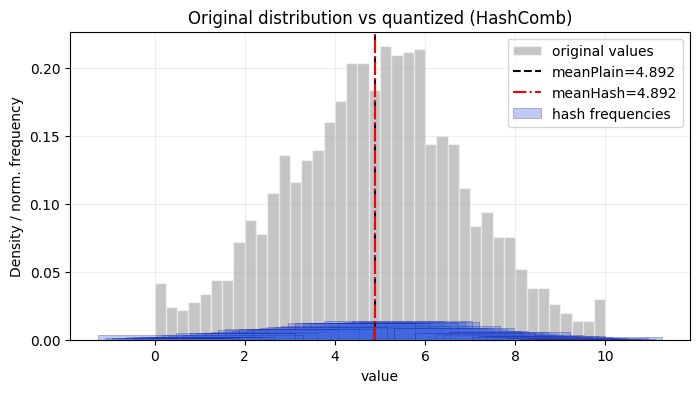

In [2]:
rng = np.random.default_rng(42)
values = rng.normal(loc=5.0, scale=2.0, size=2000)
values = np.clip(values, 0.0, 10.0)

channels = 6
enc = Encoder(channels, 10.0, 0.0, configPath="artifacts/stats_det.pkl")
dec = Decoder(configPath="artifacts/stats_det.pkl")

tokens = [enc.encode(v) for v in values]
counts = histogram_from_tokens(tokens)

stats = quantization_error(values, dec, tokens)
mean_plain = stats["mean_plain"]
mean_hash = stats["mean_hash"]
error = stats["abs_error"]

print("Mean plain:", mean_plain)
print("Mean hash :", mean_hash)
print("Abs error :", error)

plot_hash_distribution([values], counts, dec, mean_plain, mean_hash)

### 2.3 *Deterministic vs Randomized*
We compute mean estimates for both deterministic and randomized encoders.
The goal is to see how randomization affects quantization error.

In [3]:
ctx = RoundContext(salt="roundX", seed=123)
enc_det = Encoder(channels, 10.0, 0.0, roundContext=ctx, configPath="artifacts/stats_det.pkl")
enc_rand = RandomizedEncoder(
    channels,
    10.0,
    0.0,
    selectionProbability=0.6,
    roundContext=ctx,
    configPath="artifacts/stats_rand.pkl",
)

dec_det = Decoder(configPath="artifacts/stats_det.pkl")
dec_rand = Decoder(configPath="artifacts/stats_rand.pkl")

det_tokens = [enc_det.encode(v) for v in values]
rand_tokens = [enc_rand.encode(v) for v in values]

mean_det = mean_from_tokens(det_tokens, dec_det)
mean_rand = mean_from_tokens(rand_tokens, dec_rand)

summary = pd.DataFrame(
    [
        {"mode": "deterministic", "mean_hash": mean_det, "abs_error": abs(mean_plain - mean_det)},
        {"mode": "randomized", "mean_hash": mean_rand, "abs_error": abs(mean_plain - mean_rand)},
    ]
)
summary

,mode,mean_hash,abs_error
0,deterministic,4.892109,0.000469
1,randomized,4.894648,0.003008
